In [1]:
#Optimization using all experiments
#first we import all the necessary libraries
import kinetics      #this one has no use for now, but it might be used in future updates
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import least_squares
from thermo.unifac import UNIFAC, UFSG, UFIP
from thermo.chemical import Chemical
from ugropy import Groups

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-19
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-19
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-19
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-19
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-19
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-19


In [2]:
#First we define the conditions fow which we will obtain the corresponding activity coefficients and initial reaction rate
T=40+273.15    #Temperature in Kelvin
P=100000       #Pressure in Pascals
substrates_and_h2o_present=['oleic acid','ethanol','water']   #List of substrates and water present in the solution
concentration_datas=[[[0.2,0.2,0.2,0.2,0.2,0.2,0.2],'mol/L'],[[0.05,0.1,0.2,0.3,0.5,0.75,1],'mol/L'],[[0.4,0.4,0.43,0.47,0.57,0.73,0.83],'g/L']]       #List of concentration of each component present and the units they are in (they must be in mol/L or g/L)
#the order in which you submit the components name must be the same as the order in which you submit the concentrations
#the following list is in case the solvent is composed of one component
solvent_used=['hexane','heptane','cyclohexane','isooctane']               #list of solvents used in the solution
#the following list is in case the solvent is composed of two components or more
#most of the same logic applies
conc_data_fm2h=[[[0.2,0.2,0.2,0.2,0.2,0.2,0.2],'mol/L'],[[0.05,0.1,0.2,0.3,0.5,0.75,1],'mol/L'],[[7,7,7.5,8,8.5,9.5,10.5],'g/L']]
conc_data_fm2h_75_percent=[[[0.2,0.2,0.2,0.2,0.2,0.2,0.2],'mol/L'],[[0.05,0.1,0.2,0.3,0.5,0.75,1],'mol/L'],[[5.4,5.5,5.9,6,6.8,7.5,8.5],'g/L']]
conc_data_fm2h_50_percent=[[[0.2,0.2,0.2,0.2,0.2,0.2,0.2],'mol/L'],[[0.05,0.1,0.2,0.3,0.5,0.75,1],'mol/L'],[[3.9,4,4.2,4.4,5,5.5,6.4],'g/L']]
conc_data_fm2h_25_percent=[[[0.2,0.2,0.2,0.2,0.2,0.2,0.2],'mol/L'],[[0.05,0.1,0.2,0.3,0.5,0.75,1],'mol/L'],[[2.2,2.4,2.6,2.7,3.1,3.6,4.3],'g/L']]
conc_data_fm2h_10_percent=[[[0.2,0.2,0.2,0.2,0.2,0.2,0.2],'mol/L'],[[0.05,0.1,0.2,0.3,0.5,0.75,1],'mol/L'],[[0.5,0.5,0.6,0.7,0.8,0.9,1.1],'g/L']]
solvent_mixtures=[[['hexane','5-methyl-2-hexanone'],[0,1]],[['hexane','5-methyl-2-hexanone'],[0.25,0.75]],[['hexane','5-methyl-2-hexanone'],[0.5,0.5]],[['hexane','5-methyl-2-hexanone'],[0.75,0.25]],[['hexane','5-methyl-2-hexanone'],[0.9,0.1]]]     #list of solvent mixtures, where each component of the list is a list of the components present in the mixture and the other list contains the volume fraction of each component in the mixture, in order





In [3]:
#this simple function allows us to obtain the molar mass and density of a component given its name and operation conditions
#It uses the Chemical class from the thermo library
def get_component_properties(component,T,P):
    # the fed inputs are the component name, temperature in Kelvin and pressure in pascals
    component_name=Chemical(component,T=T,P=P)
    density=component_name.rho
    molar_mass=component_name.MW
    #It returns a list containing the molar mass and density of the component
    return [density,molar_mass]

In [4]:
#this function will return a list with the molar fraction of each component present in the solution for as many experiments as you want
def get_components_molar_fractions(substrates_used,concentration_data,solvent_used,T,P,is_mixture):
    #this function will return a list of molar fractions of the components present in the solution for every variation you submit
    #first, it will determine the molar mass and density of each component and solvent using Chemical from thermo
    molar_fractions=[]
    #first we get the properties of the solvent
    if is_mixture==False:
        solvent_density,solvent_molar_mass=get_component_properties(solvent_used,T,P)
        #now we will obtain the moles of the solvent
        solvent_moles=solvent_density*1/solvent_molar_mass   #assuming 1 L of solvent, we get the values in kg/m3 but to convert it to g/L we don't need to multiply by 1000
    elif is_mixture==True:
        #if the solvent is a mixture, we must calculate the moles of each component present
        number_of_components_in_mixture=len(solvent_used[0])
        solvent_moles=[]
        for i in range(number_of_components_in_mixture):
            comp_name=solvent_used[0][i]
            comp_volume_fraction=solvent_used[1][i]
            comp_density,comp_molar_mass=get_component_properties(comp_name,T,P)
            comp_moles=1*comp_volume_fraction*comp_density/comp_molar_mass  #assuming 1 L of solution
            solvent_moles.append(comp_moles)
    components_present=len(substrates_used)
    experiments_to_evaluate=len(concentration_data[0][0])    #this is the number of experiments we want to evaluate
    for i in range(experiments_to_evaluate):
        #first we want to obtain the data from the first experiment to evaluate
        experiment_concentrations=[]
        experiment_units=[]
        for j in range(components_present):
            comp_conc=concentration_data[j][0][i]   #this is the concentration of the component
            comp_unit=concentration_data[j][1]
            experiment_concentrations.append(comp_conc)
            experiment_units.append(comp_unit)
        #with this we have the concentration and units of every component present in the experiment
        #now we need to calculate the moles of each component(assuming 1 L of solution and using the molar mass and density of each component)
        components_moles=[]
        for k in range(components_present):
            comp_name=substrates_used[k]
            comp_conc=experiment_concentrations[k]
            comp_unit=experiment_units[k]
            density_k,MW_k=get_component_properties(comp_name,T,P)
            if comp_unit=='g/L':
                moles_k=(comp_conc*1)/MW_k    #assuming the 1L of solution
            elif comp_unit=='mol/L':
                moles_k=comp_conc*1
            else:
                raise ValueError('Units must be g/L or mol/L')
            components_moles.append(moles_k)
        #now we can finally calculate their molar fractions
        if is_mixture==False:
           total_moles=solvent_moles+sum(components_moles)
           k_mole_fractions=[]
           for s in range(len(components_moles)):
              mole_frac=components_moles[s]/total_moles
              k_mole_fractions.append(mole_frac)
             #we append the solvent molar fraction
           k_mole_fractions.append(solvent_moles/total_moles)
           molar_fractions.append([i+1,k_mole_fractions])   #we append the experiment number and the corresponding molar fractions of each component
        elif is_mixture==True:
            total_moles=sum(solvent_moles)+sum(components_moles)
            k_mole_fractions=[]
            for s in range(len(components_moles)):
               mole_frac=components_moles[s]/total_moles
               k_mole_fractions.append(mole_frac)
            #we append the solvent molar fraction
            for s in range(len(solvent_moles)):
                mole_frac=solvent_moles[s]/total_moles
                k_mole_fractions.append(mole_frac)
            molar_fractions.append([i+1,k_mole_fractions])

    return molar_fractions

In [5]:
#this is the most crucial function of the code, it uses the ugropy library to obtain the chemical subgroups present in each component and then uses the UNIFAC model of ones choosing to calculate the activity coefficients of each component in each experiment
def get_activity_coefficients(substrates_used,solvent_used,experiments_molar_fractions,T,P,is_mixture):
    #This function will return a list of activity coefficients for each component in each experiment
    activity_coefficients=[]
    #first we must define the chemical subgroups of every component
    chemical_subgroups=[]
    if is_mixture==False:
       number_of_comp=len(substrates_used)+ 1  #+1 for the solvent used
       list_of_all_components=substrates_used+[solvent_used]  #this creates a list with all components present in the solution
    elif is_mixture==True:
        number_of_comp=len(substrates_used)+len(solvent_used[0])
        list_of_all_components=substrates_used+solvent_used[0]  #this creates a list with all components present in the solution
    for i in range(number_of_comp):
        component_name=list_of_all_components[i]
        component_subgroups_names = Groups(component_name)
        sub = component_subgroups_names.unifac.subgroups
        # Build subgroup name-to-index dict using .group attribute
        name2idx = {UFSG[k].group: k for k in UFSG}
        # Map ugropy output to indexes
        index = {name2idx[name]: count for name, count in sub.items()}
        chemical_subgroups.append(index)
    #now that we have the chemical subgroups of each component and the molar fractions of each component in each experiment, we can get the activity coefficients for each one
    number_of_experiments=len(experiments_molar_fractions)
    for j in range(number_of_experiments):
        model=UNIFAC.from_subgroups(T=T,xs=experiments_molar_fractions[j][1],chemgroups=chemical_subgroups,subgroups=UFSG,interaction_data=UFIP,version=0)
        activity_coeffs=model.gammas()
        #we append the activity coefficients of each component of the experiment in the list
        activity_coefficients.append([j+1,activity_coeffs])  #we append the experiment number and the corresponding activity coefficients of each component
    return activity_coefficients

In [6]:
#This function determines the intial reaction rate of each experiment
def initial_reaction_rate(substrates_used,concentration_data,experimental_mole_fractions,experimental_activity_coeffs,params):
    #this function will return a list of initial reaction rates for the different experiments and plot the results
    #Comment to teach:This part would require to use a python solver to find the correct kinetic parameters from the reaction rate equation, will have preedetermined values as stand-ins for now
    initial_rx_rates=[]
    #first we define the kinetic equation
    #after going insane thinking about the system, i concluded that it is best to not use the kinetics library, instead we will directly calculate the initial reaction rate using the parameters and the activities of the components
    #initial_rx_rate=kinetics.Generic(params=['Vm','km1','km2','Ki'],species=['activity_1','activity_2'],rate_equation='(Vm*activity_1*activity_2)/(km1*activity_2*(1+activity_2/Ki)+km2*activity_1+activity_1*activity_2)')
    #we will use the activity coefficients and molar fractions to obtain the activities of the two components of interest
    number_of_experiments=len(experimental_mole_fractions)
    for i in range(number_of_experiments):
        #initial_rx_rate.parameters={'Vm':params[0],'km1':params[1],'km2':params[2],'Ki':params[3]}   #This parameters are to be perfected with a solver
        #we will use the first two components as the ones of interest
        actv_first_component=experimental_mole_fractions[i][1][0]*experimental_activity_coeffs[i][1][0]  #activity of the first component in the i experiment
        actv_second_component=experimental_mole_fractions[i][1][1]*experimental_activity_coeffs[i][1][1]  #activity of the second component in the i experiment
        #now that we set the activities of the experiment, we can calculate the corresponding initial reaction rate
        #Vi_i=kinetics.Model()
        #Vi_i.append(initial_rx_rate)
        #Vi_i.set_species={'activity_1':actv_first_component,'activity_2':actv_second_component}
        #Now with the model set we can try and run the model to see what initial reaction rate we get
        #Vi_i.setup_model()
        #initial_rate_rx_i=Vi_i.run_model()
        Vm=params[0]  #maximum initial reaction rate
        km1=params[1] #rate constant for the first component
        km2=params[2] #rate constant for the second component
        Ki=params[3] #inhibition constant
        initial_rate_rx_i=(Vm*actv_first_component*actv_second_component)/(km1*actv_second_component*(1+actv_second_component/Ki)+km2*actv_first_component+actv_first_component*actv_second_component)
        #we append the initial reaction rate of the i experiment
        initial_rx_rates.append([i+1,initial_rate_rx_i])
    return initial_rx_rates

In [ ]:
#Here is were we change the code in comparison to the previous version, the optimization will take all experiments into account, not just hexane


In [7]:
#This objective function will be used to optimize the model parameters
def objective_function_global(params,experimental_data,all_solvents,substrates_and_h2o_present,concentration_data,T,P):
    #this function will return the sum of squared differences between the experimental initial reaction rates and the calculated ones
    calculated_data=[]
    #now we will extract the initial rx rates from the calculated list
    for s in range(len(all_solvents)):
       calculated_data_for_solvent=[]
       solvent_to_get_initial_rx=all_solvents[s]
       conc_to_evaluate=concentration_data[s]
       is_mixture=isinstance(solvent_to_get_initial_rx,list)
       substrates_MF=get_components_molar_fractions(substrates_and_h2o_present,conc_to_evaluate,solvent_to_get_initial_rx,T,P,is_mixture)
       activity_coeffs=get_activity_coefficients(substrates_and_h2o_present,solvent_to_get_initial_rx,substrates_MF,T,P,is_mixture)
       initial_rx_rate=initial_reaction_rate(substrates_and_h2o_present,conc_to_evaluate,substrates_MF,activity_coeffs,params)
       for i in range(len(initial_rx_rate)):
          calculated_data_for_solvent.append(initial_rx_rate[i][1])
       calculated_data.append(calculated_data_for_solvent)
    #now that we have the calculated data, we can calculate the sum of squared differences
    exp_flat = [rate for sublist in experimental_data for rate in sublist]
    calc_flat = [rate for sublist in calculated_data for rate in sublist]
    residuals = [calc - exp for calc, exp in zip(calc_flat, exp_flat)]
    return np.array(residuals)  # least_squares will minimize the sum of squares of these
#now that we defined our objective function, we can use least_squares to optimize the model parameters

In [8]:
#This function is in charge of optimizing the model parameters
def optimize_model_parameters(experimental_rates,substrates_used,concentration_data,solvents_used,T,P,initial_params):
    #this function will return the optimized model parameters
    bounds=([0, 0, 0, 0], [np.inf, 1, 1, 1])   #bounds for the parameters
    result=least_squares(objective_function_global,initial_params, args=(experimental_rates,solvents_used, substrates_used,concentration_data,T,P), bounds=bounds)
    return result.x  #optimized parameters

In [9]:
all_solvents=solvent_used + solvent_mixtures  #this will contain all solvents and solvent mixtures
experimental_initial_rx_rates_for_each_solvent=[[0.002688075733451346, 0.0033269997642950258, 0.0022925724071250246, 0.0015921341882489818, 0.001172136785850005],[0.0019479592190416777, 0.0027590823789222467, 0.0024098397183558875, 0.002085077516501038, 0.0010060161321469432],[0.0013685199588190602, 0.0022421133554823247, 0.0017413783026799077, 0.0015237667072781467, 0.0008799532443477735],[0.0024403987269232, 0.003128098741078647, 0.0026576071818335416, 0.00225823631373946, 0.0012319986118531334],[4.089979550102209e-05, 0.0003353783231083841, 0.0004089979550102249, 0.0005316973415132921, 0.0004989775051124741], [0.00032383860881811544, 0.0007487093527437496, 0.0007454181544031266, 0.0006998006146121558, 0.0006128058231248799],[0.0005191956124314442, 0.0007239488117001831, 0.0008263254113345516, 0.0007678244972577699, 0.0006142595978062158],[0.001015267175572519, 0.0016412213740458017, 0.0012366412213740454, 0.0010687022900763363, 0.0009770992366412209],[0.0014012160496198533, 0.002190886961866612, 0.0015999748548039547, 0.0012395743477091672, 0.000942595612861767]]  #this is the experimental initial reaction rates for hexane
concentration_data_hexane=[[[0.2,0.2,0.2,0.2,0.2],'mol/L'],[[0.05,0.1,0.3,0.75,1],'mol/L'],[[0.4,0.4,0.47,0.73,0.83],'g/L']] 
concentration_data_heptane=[[[0.2,0.2,0.2,0.2,0.2],'mol/L'],[[0.05,0.1,0.2,0.3,1],'mol/L'],[[0.4,0.4,0.43,0.47,0.83],'g/L']]
concentration_data_cyclohexane=[[[0.2,0.2,0.2,0.2,0.2],'mol/L'],[[0.05,0.1,0.2,0.3,1],'mol/L'],[[0.4,0.4,0.43,0.47,0.83],'g/L']] 
concentration_data_isooctane=[[[0.2,0.2,0.2,0.2,0.2],'mol/L'],[[0.05,0.1,0.2,0.3,1],'mol/L'],[[0.4,0.4,0.43,0.47,0.83],'g/L']]  
conc_data_fm2h=[[[0.2,0.2,0.2,0.2,0.2],'mol/L'],[[0.05,0.1,0.2,0.75,1],'mol/L'],[[7,7,7.5,9.5,10.5],'g/L']]
conc_data_fm2h_75_percent=[[[0.2,0.2,0.2,0.2,0.2],'mol/L'],[[0.05,0.2,0.5,0.75,1],'mol/L'],[[5.4,5.9,6.8,7.5,8.5],'g/L']]
conc_data_fm2h_50_percent=[[[0.2,0.2,0.2,0.2,0.2],'mol/L'],[[0.05,0.1,0.5,0.75,1],'mol/L'],[[3.9,4,5,5.5,6.4],'g/L']]
conc_data_fm2h_25_percent=[[[0.2,0.2,0.2,0.2,0.2],'mol/L'],[[0.05,0.2,0.5,0.75,1],'mol/L'],[[2.2,2.6,3.1,3.6,4.3],'g/L']]
conc_data_fm2h_10_percent=[[[0.2,0.2,0.2,0.2,0.2],'mol/L'],[[0.05,0.2,0.5,0.75,1],'mol/L'],[[0.5,0.6,0.8,0.9,1.1],'g/L']]
all_conc_data=[concentration_datas,concentration_datas,concentration_datas,concentration_datas,conc_data_fm2h,conc_data_fm2h_75_percent,conc_data_fm2h_50_percent,conc_data_fm2h_25_percent,conc_data_fm2h_10_percent]

In [10]:
initial_params=[20,0.1,0.1,0.1]  
optimized_params=optimize_model_parameters(experimental_initial_rx_rates_for_each_solvent,substrates_and_h2o_present,all_conc_data,all_solvents,T,P,initial_params)

In [11]:
print("optimized parameters: ",optimized_params)

optimized parameters:  [1.67420659e-03 1.21848982e-07 2.34016835e-02 7.91124205e-05]


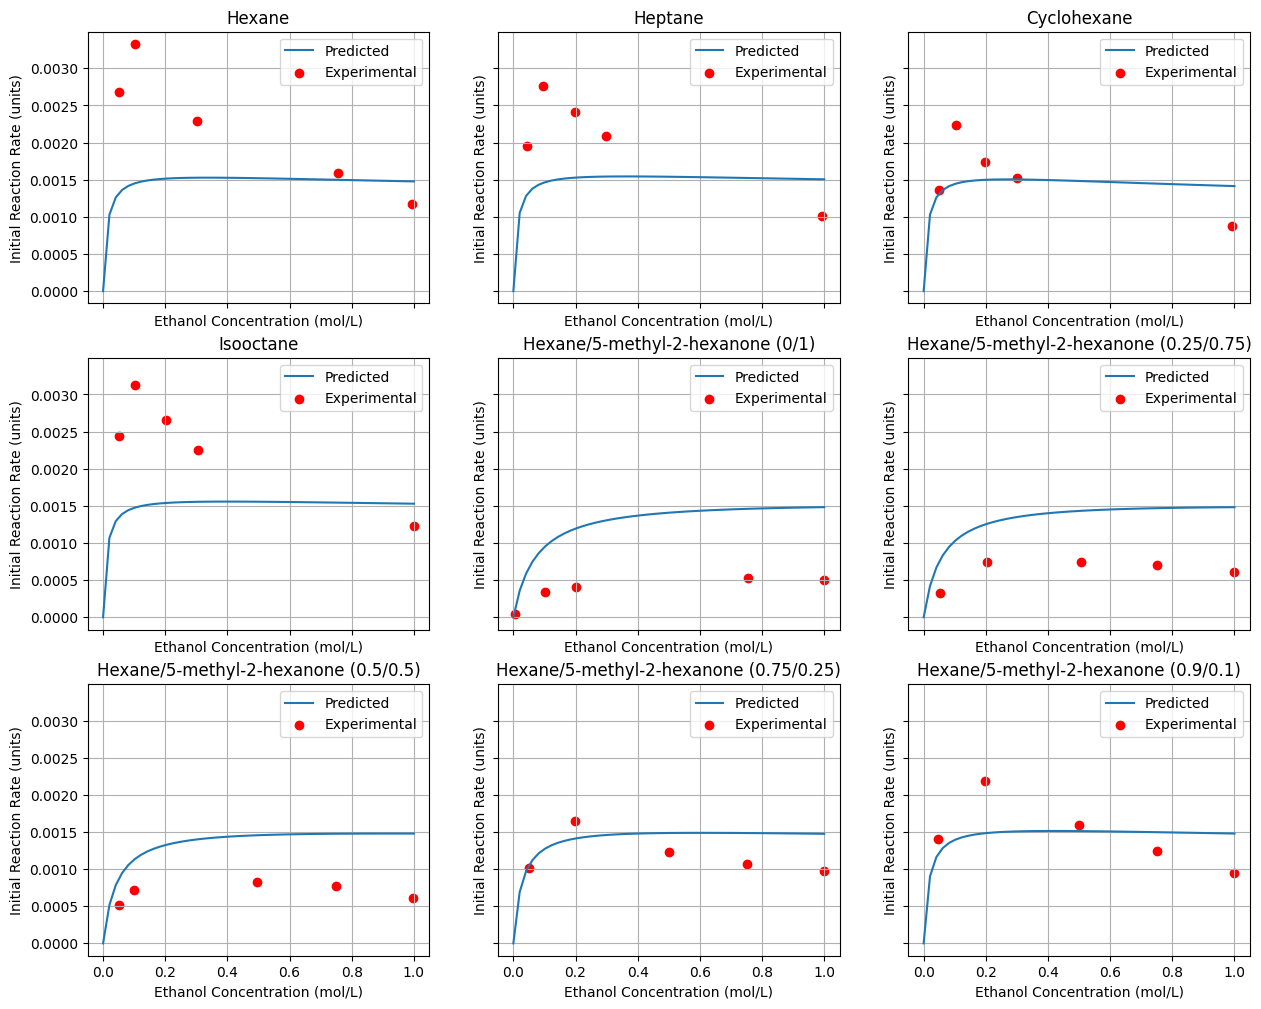

In [12]:
#to finalize, we will plot the initial reaction rates predictions for each solvent along with the experimental values
#first, we will need to create a list with the experimental results for the different solvents
experimental_conc_points=[[ 0.05075281826219876, 0.10134351835372094, 0.3014810939384415, 0.7549437915790792, 0.9946268886462357],[0.043583535108958856, 0.09685230024213038, 0.19854721549636787, 0.297820823244552, 0.9927360774818403],[0.0480549199084666, 0.10297482837528594, 0.1967963386727688, 0.299771167048055, 0.9931350114416473],[0.052110302880861475, 0.10350370096939405, 0.2031671666735163, 0.3052233592240994, 1],[0.0036968576709796355, 0.10166358595194084, 0.20147874306839188, 0.7541589648798522, 1.0],[0.05175600739371536, 0.20332717190388176, 0.5046210720887244, 0.7504621072088726, 0.9981515711645101],[0.05040650406504065, 0.10081300813008133, 0.4959349593495935, 0.7495934959349593, 0.9967479674796749],[0.05067641004002201, 0.1983422200058818, 0.5013553773958853, 0.7525413326172849, 1.0],[0.04648019641192028, 0.1985038608353095, 0.49983061916552877, 0.7501126295239524, 0.9968952667660833]]
experimental_initial_rx_rates_for_each_solvent=[[0.002688075733451346, 0.0033269997642950258, 0.0022925724071250246, 0.0015921341882489818, 0.001172136785850005],[0.0019479592190416777, 0.0027590823789222467, 0.0024098397183558875, 0.002085077516501038, 0.0010060161321469432],[0.0013685199588190602, 0.0022421133554823247, 0.0017413783026799077, 0.0015237667072781467, 0.0008799532443477735],[0.0024403987269232, 0.003128098741078647, 0.0026576071818335416, 0.00225823631373946, 0.0012319986118531334],[4.089979550102209e-05, 0.0003353783231083841, 0.0004089979550102249, 0.0005316973415132921, 0.0004989775051124741], [0.00032383860881811544, 0.0007487093527437496, 0.0007454181544031266, 0.0006998006146121558, 0.0006128058231248799],[0.0005191956124314442, 0.0007239488117001831, 0.0008263254113345516, 0.0007678244972577699, 0.0006142595978062158],[0.001015267175572519, 0.0016412213740458017, 0.0012366412213740454, 0.0010687022900763363, 0.0009770992366412209],[0.0014012160496198533, 0.002190886961866612, 0.0015999748548039547, 0.0012395743477091672, 0.000942595612861767]]  #this is the experimental initial reaction rates for hexane
ethanol_conc_range=np.linspace(0,1,50)  #range of ethanol concentrations for plotting
water_conc=[0.6,0.6,0.6,0.6,8.5,6.2,4.5,2.6,0.6]    #water concentration to evaluate for each solvent
all_solvents=solvent_used + solvent_mixtures  #this will contain all solvents and solvent mixtures
ncols=3
nrows=int(np.ceil(len(all_solvents)/ncols))   
fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), sharex=True, sharey=True)
axs = axs.flatten()
for s in range(len(all_solvents)):
    solvent_to_plot=all_solvents[s]
    initial_rx_rates_predictions=[]
    for k in range(len(ethanol_conc_range)):
        #we will calculate the initial rx rate for each ethanol concentration in the range
        evaluated_conc=ethanol_conc_range[k]
        water_evaluated=water_conc[s]
        concentration_datasexp=[[[0.2],'mol/L'],[[evaluated_conc],'mol/L'],[[water_evaluated],'g/L']]  #for each solvent we have a specific water concentration to evaluate
        #now we must determine if this is a mixture or not
        is_mixture=isinstance(solvent_to_plot,list)
        substrates_MF=get_components_molar_fractions(substrates_and_h2o_present,concentration_datasexp,solvent_to_plot,T,P,is_mixture)
        activity_coeffs=get_activity_coefficients(substrates_and_h2o_present,solvent_to_plot,substrates_MF,T,P,is_mixture)
        initial_rx_rate=initial_reaction_rate(substrates_and_h2o_present,concentration_datasexp,substrates_MF,activity_coeffs,optimized_params)
        initial_rx_rates_predictions.append(initial_rx_rate[0][1])
    #now we can plot the initial rx rates
    #prepare label for solvent or mixture
    if isinstance(solvent_to_plot, str):
        title=solvent_to_plot.capitalize()
    else:
        comps="/".join([c.capitalize() for c in solvent_to_plot[0]])
        fractions = "/".join([str(f) for f in solvent_to_plot[1]])
        title=f"{comps} ({fractions})"
    ax=axs[s]
    ax.plot(ethanol_conc_range, initial_rx_rates_predictions, label='Predicted')
    ax.scatter(experimental_conc_points[s],experimental_initial_rx_rates_for_each_solvent[s],color='red',label='Experimental')
    ax.set_xlabel("Ethanol Concentration (mol/L)")
    ax.set_ylabel("Initial Reaction Rate (units)")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
plt.show()
